In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import collections
from sklearn import preprocessing
from sklearn import metrics
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from scipy import stats
import seaborn as sns

In [0]:
train_data = pd.read_csv('./drive/My Drive/BT4240 data/result.csv')\
              .drop(columns=['Unnamed: 0', 'Unnamed: 0.1'],axis=1)
train_data.head()

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,description,total_cost,Project Resource Category,Project Need Statement
0,p039565,df72a3ba8089423fa8a94be88060f6ed,Mrs.,GA,2017-04-26 15:57:28,Grades 3-5,"Music & The Arts, Health & Sports","Performing Arts, Team Sports",Keep Calm and Dance On,Our elementary school is a culturally rich sch...,We strive to provide our diverse population of...,NaN,NaN,My students need matching shirts to wear for d...,1,0,{Reebok Girls' Fashion Dance Graphic T-Shirt -...,400.00,Supplies,My students need matching shirts to wear for d...
1,p063374,403c6783e9286e51ab318fba40f8d729,Mrs.,DE,2016-11-05 10:01:51,Grades PreK-2,"Applied Learning, Literacy & Language","Character Education, Literature & Writing",Need to Reach Our Virtual Mentors!!!,My kids tell me each day that they want to mak...,I started a program called Telementoring in ho...,NaN,NaN,My students need tablets in order to communic...,0,1,{Amazon - Fire Kids Edition - 7'- Tablet - 16G...,727.36,Technology,My students need tablets in order to communic...
2,p114989,b580c11b1497a0a67317763b7f03eb27,Ms.,IN,2016-09-13 22:35:57,Grades 6-8,Math & Science,Mathematics,Wobble Chairs Help Fidgety Kids Focus,My seventh graders dream big. They can't wait ...,I have used alternative seating in my classroo...,NaN,NaN,My students need seating that allows the most ...,13,1,"{Kore Patented WOBBLE Chair, Made in the USA, ...",319.80,Supplies,My students need seating that allows the most ...
3,p030093,b9e731e16ad8669f37a43e5316518106,Teacher,VA,2017-03-09 17:16:13,Grades PreK-2,"Literacy & Language, Math & Science","Literature & Writing, Mathematics","Writing, Writing, Writing!",My classroom has 24 students in it. We have an...,"In our classroom, we use dry erase boards thro...",NaN,NaN,My students need individual dry erase boards t...,1,1,{BOARD LEARNING THE CLASSICS W/MARKER},102.00,Supplies,My students need individual dry erase boards t...
4,p225747,4681d60136ea859084ab488f2254b219,Ms.,PA,2016-12-08 13:25:03,Grades 3-5,"Applied Learning, Literacy & Language","Character Education, Literacy",Life Lessons through Literacy,"My school is located in a high poverty area, j...",As a Reading Specialist who serves Grades 1-8 ...,NaN,NaN,My students need books that teach life lessons...,3,1,"{A Bad Case of Stripes (Scholastic Bookshelf),...",176.59,Books,My students need books that teach life lessons...


In [0]:
train_data.shape

(121308, 20)

In [0]:
train_data.columns

Index(['id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category',
       'project_subject_categories', 'project_subject_subcategories',
       'project_title', 'project_essay_1', 'project_essay_2',
       'project_essay_3', 'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'description', 'total_cost', 'Project Resource Category',
       'Project Need Statement'],
      dtype='object')

In [0]:
train_data['project_subject_categories'] = train_data['project_subject_categories'].str.split(", ").to_frame()
train_data['project_subject_subcategories'] = train_data['project_subject_subcategories'].str.split(", ").to_frame()
train_data['Project Resource Category'] = train_data['Project Resource Category'].str.split(", ").to_frame()

train_data.head(1)

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,description,total_cost,Project Resource Category,Project Need Statement
0,p039565,df72a3ba8089423fa8a94be88060f6ed,Mrs.,GA,2017-04-26 15:57:28,Grades 3-5,"[Music & The Arts, Health & Sports]","[Performing Arts, Team Sports]",Keep Calm and Dance On,Our elementary school is a culturally rich sch...,We strive to provide our diverse population of...,NaN,NaN,My students need matching shirts to wear for d...,1,0,{Reebok Girls' Fashion Dance Graphic T-Shirt -...,400.0,[Supplies],My students need matching shirts to wear for d...


In [0]:
train_data['project_subject_categories'] = train_data['project_subject_categories'].apply(collections.Counter)
train_data['project_subject_subcategories'] = train_data['project_subject_subcategories'].apply(collections.Counter)
train_data['Project Resource Category'] = train_data['Project Resource Category'].apply(collections.Counter)

project_subject_categories = pd.DataFrame.from_records(train_data['project_subject_categories']).fillna(value=0).add_prefix("proj_cat_")
project_subject_subcategories = pd.DataFrame.from_records(train_data['project_subject_subcategories']).fillna(value=0).add_prefix("proj_sub_cat_")
Project_Resource_Category = pd.DataFrame.from_records(train_data['Project Resource Category']).fillna(value=0).add_prefix("res_cat_")


train_data = pd.concat([train_data, project_subject_categories], axis=1)
train_data = pd.concat([train_data, project_subject_subcategories], axis=1)
train_data = pd.concat([train_data, Project_Resource_Category], axis=1)

train_data.head(5)

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,description,total_cost,Project Resource Category,Project Need Statement,proj_cat_Music & The Arts,proj_cat_Health & Sports,proj_cat_Applied Learning,proj_cat_Literacy & Language,proj_cat_Math & Science,proj_cat_Special Needs,proj_cat_History & Civics,proj_cat_Warmth,proj_cat_Care & Hunger,proj_sub_cat_Performing Arts,proj_sub_cat_Team Sports,proj_sub_cat_Character Education,proj_sub_cat_Literature & Writing,proj_sub_cat_Mathematics,proj_sub_cat_Literacy,proj_sub_cat_Special Needs,proj_sub_cat_Early Development,proj_sub_cat_Environmental Science,proj_sub_cat_Health & Wellness,proj_sub_cat_Music,proj_sub_cat_Applied Sciences,proj_sub_cat_Visual Arts,proj_sub_cat_ESL,proj_sub_cat_Extracurricular,proj_sub_cat_Gym & Fitness,proj_sub_cat_History & Geography,proj_sub_cat_College & Career Prep,proj_sub_cat_Health & Life Science,proj_sub_cat_Other,proj_sub_cat_Warmth,proj_sub_cat_Care & Hunger,proj_sub_cat_Social Sciences,proj_sub_cat_Foreign Languages,proj_sub_cat_Parent Involvement,proj_sub_cat_Nutrition Education,proj_sub_cat_Civics & Government,proj_sub_cat_Community Service,proj_sub_cat_Financial Literacy,proj_sub_cat_Economics,res_cat_Supplies,res_cat_Technology,res_cat_Books,res_cat_Other,res_cat_Computers & Tablets,res_cat_Food,res_cat_Clothing & Hygiene,res_cat_Flexible Seating,res_cat_Reading Nooks,res_cat_Desks & Storage,res_cat_Instructional Technology,res_cat_Classroom Basics,res_cat_Educational Kits & Games,res_cat_Sports & Exercise Equipment,res_cat_Musical Instruments,res_cat_Art Supplies,res_cat_Lab Equipment,res_cat_Visitors
0,p039565,df72a3ba8089423fa8a94be88060f6ed,Mrs.,GA,2017-04-26 15:57:28,Grades 3-5,"{'Music & The Arts': 1, 'Health & Sports': 1}","{'Performing Arts': 1, 'Team Sports': 1}",Keep Calm and Dance On,Our elementary school is a culturally rich sch...,We strive to provide our diverse population of...,NaN,NaN,My students need matching shirts to wear for d...,1,0,{Reebok Girls' Fashion Dance Graphic T-Shirt -...,400.00,{'Supplies': 1},My students need matching shirts to wear for d...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,p063374,403c6783e9286e51ab318fba40f8d729,Mrs.,DE,2016-11-05 10:01:51,Grades PreK-2,"{'Applied Learning': 1, 'Literacy & Language': 1}","{'Character Education': 1, 'Literature & Writi...",Need to Reach Our Virtual Mentors!!!,My kids tell me each day that they want to mak...,I started a program called Telementoring in ho...,NaN,NaN,My students need tablets in order to communic...,0,1,{Amazon - Fire Kids Edition - 7'- Tablet - 16G...,727.36,{'Technology': 1},My students need tablets in order to communic...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,p114989,b580c11b1497a0a67317763b7f03eb27,Ms.,IN,2016-09-13 22:35:57,Grades 6-8,{'Math & Science': 1},{'Mathematics': 1},Wobble Chairs Help Fidgety Kids Focus,My seventh graders dream big. They can't wait ...,I have used alternative seating in my classroo...,NaN,NaN,My students need seating that allows the most ...,13,1,"{Kore Patented WOBBLE Chair, Made in the USA, ...",319.80,{'Supplies': 1},My students need seating that allows the most ...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [0]:
!pip install iteration_utilities
from iteration_utilities import duplicates
list(duplicates(train_data.columns))

     |████████████████████████████████| 276kB 2.7MB/s 


[]

In [0]:
train_data = train_data.loc[:,~train_data.columns.duplicated()]
train_data = train_data.drop(columns = ['proj_sub_cat_Care & Hunger', 'proj_sub_cat_Special Needs', 'proj_sub_cat_Warmth'])
len(train_data.columns)

74

In [0]:
train_df = train_data.select_dtypes(exclude=['object','category'])
print(len(train_df.columns))
print(train_df.dtypes.unique())
cat_columns = [col for col in train_df.columns if 'cat' in col]
train_df.head(1)

57
[dtype('int64') dtype('float64')]


,teacher_number_of_previously_posted_projects,project_is_approved,total_cost,proj_cat_Music & The Arts,proj_cat_Health & Sports,proj_cat_Applied Learning,proj_cat_Literacy & Language,proj_cat_Math & Science,proj_cat_Special Needs,proj_cat_History & Civics,proj_cat_Warmth,proj_cat_Care & Hunger,proj_sub_cat_Performing Arts,proj_sub_cat_Team Sports,proj_sub_cat_Character Education,proj_sub_cat_Literature & Writing,proj_sub_cat_Mathematics,proj_sub_cat_Literacy,proj_sub_cat_Early Development,proj_sub_cat_Environmental Science,proj_sub_cat_Health & Wellness,proj_sub_cat_Music,proj_sub_cat_Applied Sciences,proj_sub_cat_Visual Arts,proj_sub_cat_ESL,proj_sub_cat_Extracurricular,proj_sub_cat_Gym & Fitness,proj_sub_cat_History & Geography,proj_sub_cat_College & Career Prep,proj_sub_cat_Health & Life Science,proj_sub_cat_Other,proj_sub_cat_Social Sciences,proj_sub_cat_Foreign Languages,proj_sub_cat_Parent Involvement,proj_sub_cat_Nutrition Education,proj_sub_cat_Civics & Government,proj_sub_cat_Community Service,proj_sub_cat_Financial Literacy,proj_sub_cat_Economics,res_cat_Supplies,res_cat_Technology,res_cat_Books,res_cat_Other,res_cat_Computers & Tablets,res_cat_Food,res_cat_Clothing & Hygiene,res_cat_Flexible Seating,res_cat_Reading Nooks,res_cat_Desks & Storage,res_cat_Instructional Technology,res_cat_Classroom Basics,res_cat_Educational Kits & Games,res_cat_Sports & Exercise Equipment,res_cat_Musical Instruments,res_cat_Art Supplies,res_cat_Lab Equipment,res_cat_Visitors
0,1,0,400.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
train_df[cat_columns] = train_df[cat_columns].astype('int8')
train_df.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,teacher_number_of_previously_posted_projects,project_is_approved,total_cost,proj_cat_Music & The Arts,proj_cat_Health & Sports,proj_cat_Applied Learning,proj_cat_Literacy & Language,proj_cat_Math & Science,proj_cat_Special Needs,proj_cat_History & Civics,proj_cat_Warmth,proj_cat_Care & Hunger,proj_sub_cat_Performing Arts,proj_sub_cat_Team Sports,proj_sub_cat_Character Education,proj_sub_cat_Literature & Writing,proj_sub_cat_Mathematics,proj_sub_cat_Literacy,proj_sub_cat_Early Development,proj_sub_cat_Environmental Science,proj_sub_cat_Health & Wellness,proj_sub_cat_Music,proj_sub_cat_Applied Sciences,proj_sub_cat_Visual Arts,proj_sub_cat_ESL,proj_sub_cat_Extracurricular,proj_sub_cat_Gym & Fitness,proj_sub_cat_History & Geography,proj_sub_cat_College & Career Prep,proj_sub_cat_Health & Life Science,proj_sub_cat_Other,proj_sub_cat_Social Sciences,proj_sub_cat_Foreign Languages,proj_sub_cat_Parent Involvement,proj_sub_cat_Nutrition Education,proj_sub_cat_Civics & Government,proj_sub_cat_Community Service,proj_sub_cat_Financial Literacy,proj_sub_cat_Economics,res_cat_Supplies,res_cat_Technology,res_cat_Books,res_cat_Other,res_cat_Computers & Tablets,res_cat_Food,res_cat_Clothing & Hygiene,res_cat_Flexible Seating,res_cat_Reading Nooks,res_cat_Desks & Storage,res_cat_Instructional Technology,res_cat_Classroom Basics,res_cat_Educational Kits & Games,res_cat_Sports & Exercise Equipment,res_cat_Musical Instruments,res_cat_Art Supplies,res_cat_Lab Equipment,res_cat_Visitors
0,1,0,400.00,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,727.36,0,0,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,13,1,319.80,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,102.00,0,0,0,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3,1,176.59,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
train_data["Combined Project Essay"] = train_data["project_essay_1"] +	train_data["project_essay_2"] 
train_data["Combined Project Essay"]

0         Our elementary school is a culturally rich sch...
1         My kids tell me each day that they want to mak...
2         My seventh graders dream big. They can't wait ...
3         My classroom has 24 students in it. We have an...
4         My school is located in a high poverty area, j...
                                ...                        
121303    I am blessed to work in a rural, but quickly g...
121304    I have a group of inspiring students who will ...
121305    My students in my class are sixth, seventh and...
121306    I work with a group of wonderful second grade ...
121307    Balanced literacy was a mystery to me until a ...
Name: Combined Project Essay, Length: 121308, dtype: object

In [0]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english"))
from nltk.stem.porter import PorterStemmer
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy


from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import log_loss,confusion_matrix,classification_report,roc_curve,auc

import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from scipy import sparse
%matplotlib inline


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [0]:
##Remove punctuation, lower case, numbers from text 
# Load the regular expression library
import re
stop_words = stopwords.words('english')

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def lemmatization(texts, tags=['NOUN', 'ADJ', 'VERB']): # filter noun and adjective
    output = []
    for sent in texts:
      doc = nlp(" ".join(sent)) 
      output.append([token.lemma_ for token in doc if token.pos_ in tags])
    return output
    
def remove_stopwords(rev):
    rev_new = " ".join([i for i in rev if i not in stop_words])
    return rev_new

def preprocess(dataframe, column, newcolumn):#column: Combined Project Essay, newcolumn=essay_processed
    dataframe[newcolumn]=dataframe[column].map(lambda x: re.sub('[,&#\.!?;></]', '', x))#remove punc
    dataframe[newcolumn] = dataframe[newcolumn].map(lambda x: x.lower())#lowercase
    dataframe[newcolumn] = dataframe[newcolumn].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))
    essay12 = [remove_stopwords(r.split()) for r in dataframe[newcolumn]]
    tokenized_essay12 = pd.Series(essay12).apply(lambda x: x.split())
    #lemmatization
    essay12_2 = lemmatization(tokenized_essay12)
    essay12_3 = []
    for i in range(len(essay12_2)):
        essay12_3.append(' '.join(essay12_2[i]))

    dataframe[newcolumn] = essay12_3
    return essay12_2

In [0]:
preprocess(train_data, 'Combined Project Essay', 'essay_processed')

[['elementary',
  'school',
  'rich',
  'school',
  'diverse',
  'population',
  'student',
  'pre',
  '-',
  'k',
  'sixth',
  'title',
  'school',
  'population',
  '%',
  'student',
  'qualify',
  'free',
  'reduce',
  'price',
  'lunch',
  'high',
  'concentration',
  'english',
  'learner',
  'serve',
  'foster',
  'group',
  'home',
  'temporary',
  'long',
  'term',
  'placement',
  'homeless',
  'child',
  'see',
  'statistic',
  'road',
  'block',
  'see',
  'addition',
  'rich',
  'diversity',
  'help',
  'student',
  'develop',
  'full',
  'potential',
  'creative',
  'problem',
  'solve',
  'compassionate',
  'adultswe',
  'strive',
  'provide',
  'diverse',
  'population',
  'student',
  'extra',
  'curricular',
  'activity',
  'outlet',
  'express',
  'creativelyas',
  'teacher',
  'organize',
  'dance',
  'club',
  'low',
  'elementary',
  'meet',
  'week',
  'give',
  'girl',
  'something',
  'look',
  'foster',
  'education',
  'whole',
  'child',
  'create',
  'social

In [0]:
preprocess(train_data, 'project_resource_summary', 'need_processed')

[['student',
  'need',
  'matching',
  'shirt',
  'wear',
  'dance',
  'performance',
  'competition'],
 ['student',
  'need',
  'tablet',
  'order',
  'communicate',
  'virtual',
  'mentor',
  'program',
  'start',
  'call',
  'telementore',
  'student',
  'exchange',
  'message',
  'share',
  'online',
  'folder',
  'video',
  'chat',
  'read',
  'digital',
  'book'],
 ['student',
  'need',
  'seat',
  'allow',
  'fidgety',
  'move',
  'learn',
  'chair',
  'great',
  'classroom',
  'stool',
  'allow',
  'student',
  'wobble',
  'learn'],
 ['student',
  'need',
  'individual',
  'dry',
  'erase',
  'board',
  'show',
  'work',
  'think',
  'whole',
  'group',
  'lesson',
  'small',
  'group',
  'lesson',
  'independent',
  'activity'],
 ['student',
  'need',
  'book',
  'teach',
  'life',
  'lesson',
  'promote',
  'discussion',
  'good',
  'people'],
 ['student',
  'need',
  'good',
  'book',
  'life',
  'lesson',
  'adventure',
  'stimulate',
  'curious',
  'mind',
  'demonstrate',

In [0]:
df=train_data.drop_duplicates(subset={'Combined Project Essay', 'project_resource_summary'})
df.shape

(93788, 77)

### Export to csv 
- After data cleaning, export to csv and reupload again 
- THis is to save time 

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from google.colab import files
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)



In [0]:
df.to_csv('donorsnlp1.csv')

In [0]:
file_list = drive.ListFile({'q': "'root' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

title: BT4240 Report, id: 1R6r_e-r5Zt7clnDydGup3Fr-L4BKhMd_kaBEKuC8DA4
title: BT4221_Big Data, id: 1NiBD___zlindibxuPyUv5rpmyLNpSiXv
title: BT4222, id: 1iOVn2pbslRay7ZWsQKnqL8EFvHrR1NDi
title: Models, id: 110s8R4cwcVViYLnfNx91soPJ5OlofGt6
title: logistic_regression_sy.ipynb, id: 1mCelVJnQoj9s7_XPcSYEtzGjG-iG61W7
title: Colab Notebooks, id: 1tZc_1isH-5xPtouttjzK2v8uxOJeH21b
title: BT4240 data, id: 144-oztZZwtiJs5BSQzZ7lRn9iiCCE0ve
title: Getting started, id: 0BzwaTM8V-DJ1c3RhcnRlcl9maWxl


In [0]:
file = drive.CreateFile({'parents':[{u'id': '144-oztZZwtiJs5BSQzZ7lRn9iiCCE0ve'}]}) 
file.SetContentFile("donorsnlp1.csv")
file.Upload()

## Dont run

In [0]:
#remove duplicates 
df = train_data.drop_duplicates(subset={"essay_processed"})

In [0]:
#remove duplicates 
df = df.drop_duplicates(subset={"need_processed"})

In [0]:
df['need_processed'] #Question : do we remove the duplicates in need_processed (project need statement)

0         student need matching shirt wear dance perform...
1         student need tablet order communicate virtual ...
2         student need seat allow fidgety move learn cha...
3         student need individual dry erase board show w...
4         student need book teach life lesson promote di...
5         student need good book life lesson adventure s...
6         student need flexible seating option promote l...
7         student need cushion sit center small group ac...
8         student need opportunity develop oral language...
9         student need level reader maximize independent...
10        student need earbud headphone use classroom ch...
11        student need pad classroom assist success 21st...
12        student need wobble chair help build balancing...
13        student need access quality replacement reed c...
14        student need ipad case show learn parent stude...
23        student need engage read math way inspire mini...
24        student need dice sand timer m

In [0]:
df.shape

(91009, 77)

In [0]:
#vals = {}
#num = train_data['Combined Project Essay'].count()
# Remove the stop words and punctuations 
#for x in range(0, 10):
#  test = [w for w in word_tokenize(train_data['Combined Project Essay'].iloc[x]) if not w in stop_words]
#  vals[x] = [word.lower() for word in test if word.isalpha()]

# Stem the words
#porter = PorterStemmer()

#Change it to lemmatization 

#wordnet_lemmatizer = WordNetLemmatizer()
#for x in range(0,10):
#  fin_val = []
#  for t in vals[x]:    
#    fin_val.append(wordnet_lemmatizer.lemmatize(t, pos="v"))
#  vals[x] = fin_val 

#list(vals.values())[1:3]
  
# Get TFIDF for each combined project essay





 

Handling imbalanced dataset 

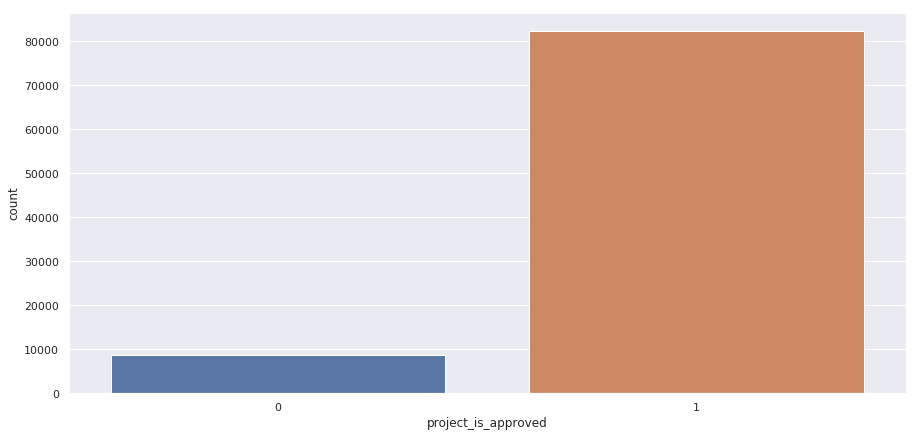

In [0]:
import matplotlib.pyplot as plt
#Distribution of scores 
count_approve_plot = df[["id","project_is_approved"]].drop_duplicates()
sns.set(font_scale=1)
a4_dims = (15, 7)
fig, ax = plt.subplots(figsize=a4_dims)
sns.countplot(ax=ax, x="project_is_approved", data=count_approve_plot)

# Downsampling

In [0]:
#From the above bar plot, we can tell that the number of projects being approved is way too significantly higher than non approved. 
#We can start by doing undersampling (removing class 1 labels from the data)
from sklearn.utils import resample
train_majority = df[df.project_is_approved==0]
train_minority = df[df.project_is_approved==1]
 
train_majority_downsampled = resample(train_majority, 
                                 replace=True,  
                                 n_samples=len(train_minority),   
                                 random_state=123)
train_downsampled = pd.concat([train_majority_downsampled, train_minority])
train_downsampled['project_is_approved'].value_counts()

1    82351
0    82351
Name: project_is_approved, dtype: int64

Split the training data, validation and test data set

In [0]:
X = train_downsampled.loc[:, train_downsampled.columns != 'project_is_approved']
y = train_downsampled.loc[:, train_downsampled.columns == 'project_is_approved']
#y = df.loc[:, df.columns == 'project_is_approved']

In [0]:
train_downsampled.shape

(164702, 77)

In [0]:
y.shape

(164702, 1)

In [0]:
# split X, Y to train, valid and test by 6:2:2

X_train1, X_test, y_train1, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train1, y_train1, test_size=0.2, random_state=1)
print("Train: {}, Validation: {}, Test: {}".format(X_train.shape, X_val.shape, X_test.shape))
print("Train: {}, Validation: {}, Test: {}".format(y_train.shape, y_val.shape, y_test.shape))

Train: (105408, 76), Validation: (26353, 76), Test: (32941, 76)
Train: (105408, 1), Validation: (26353, 1), Test: (32941, 1)


### Stochastic Gradient Descent Classifier

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
pipeline_sgd = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf',  TfidfTransformer()),
    ('nb', SGDClassifier()),
])

In [0]:
model = pipeline_sgd.fit(X_train['need_processed'], y_train)
y_predict = model.predict(X_val['need_processed'])
from sklearn.metrics import f1_score
f1_score(y_val, y_predict)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.6905865314989138

In [0]:
model_essay = pipeline_sgd.fit(X_train['essay_processed'], y_train)
y_predict_essay = model_essay.predict(X_val['essay_processed'])
from sklearn.metrics import f1_score
f1_score(y_val, y_predict_essay)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7067151628925652

### Please dont run below : Not yet using this 

TF-IDF

In [0]:
print('Fitting and transforming train on essays')
word_vec_output_train = essay_vectorizer.fit_transform(X_train['essay_processed'])
print('Transforming validation on essays') #instead on test 
word_vec_output_val = essay_vectorizer.transform(X_val['essay_processed'])
print('==== Essay vectorization complete ====')

Fitting and transforming train on essays
Transforming validation on essays
==== Essay vectorization complete ====


In [0]:
print('Fitting and transforming train on project need statement')
need_vec_output_train = cat_vectorizer.fit_transform(X_train['need_processed'])
print('Transforming validation on project need statement') #instead on test 
need_vec_output_val = cat_vectorizer.transform(X_val['need_processed'])
print('==== Project need statement vectorization complete ====')

Fitting and transforming train on project need statement
Transforming validation on project need statement
==== Project need statement vectorization complete ====


In [0]:
print('==== Forming y ====')
# Based off the methods I was using (and testing, though not shown) it was easier to be a sparse matrix.
y = df['project_is_approved'].to_sparse().as_matrix()

print('==== Forming X ====')
#X = pd.concat(useful_data_train, axis=1).to_sparse().as_matrix()


==== Forming y ====
==== Forming X ====


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
from scipy.sparse import hstack
X = hstack((word_vec_output_train, need_vec_output_train))
Xval = hstack((word_vec_output_val, need_vec_output_val))

In [0]:
word_vec_output_train

<58245x4500 sparse matrix of type '<class 'numpy.float64'>'
	with 4483329 stored elements in Compressed Sparse Row format>

In [0]:
y.shape

(91009,)

Grid Search

In [0]:
from sklearn.model_selection import GridSearchCV
parameters = [{'penalty':['l1'],'solver':['liblinear', 'saga'], 'C':[ .1, .3, 1, 3]},
               {'penalty':['l2'],'solver':['liblinear', 'newton-cg', 'lbfgs', 'sag'], 'C':[ .1, .3, 1, 3]}]
lg = LogisticRegression()
clf = GridSearchCV(lg, parameters, scoring='roc_auc', verbose=1)
clf.fit(X, y)
print("Best parameters set found on training data:")
print(clf.best_params_)
print("Best score found using these parameters:")
print(clf.best_score_)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


ValueError: ignored

Cross Validation

In [0]:
print('=== Start cross-validation ====')
clf = LogisticRegression(C=1.0, 
                         penalty='l1', 
                         solver='liblinear',
                         max_iter=500,
                         n_jobs=1)
scores = cross_val_score(clf, X, y, cv=5, scoring='roc_auc', verbose=2)
print('Cross-validation score: {}'.format(scores))
print('Cross-validation score: {}'.format(sum(scores)/5))
print('=== Finished cross-validation ====')



In [0]:
print('==== Starting fitting ====')
clf.fit(X, y)
print('Starting predicting.')
#pred = clf.predict_proba(Xval)[:,1]


pred =  lr.predict(Xval)
print('\nConfusion matrix\n',confusion_matrix(y_val,pred))
print(classification_report(y_val,pred))

Please dont run below : Not yet using this 

In [0]:
X_train['essay_processed'].fillna(' ', inplace=True)
X_test['essay_processed'].fillna(' ',inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [0]:
from imblearn.over_sampling import SMOTE 

# use SMOTE with only the train set
os = SMOTE(random_state=1)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns

os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['project_is_approved'])

# we can check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of not approved in oversampled data",len(os_data_y[os_data_y['project_is_approved']==0]))
print("Number of approved in oversampled data",len(os_data_y[os_data_y['project_is_approved']==1]))
print("Proportion of not approved data in oversampled data is ",len(os_data_y[os_data_y['project_is_approved']==0])/len(os_data_X))
print("Proportion of approved data in oversampled data is ",len(os_data_y[os_data_y['project_is_approved']==1])/len(os_data_X))


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


ValueError: ignored

In [0]:
import numpy as np
print("Creating Word Features Matrix..")
# build TFIDF Vectorizer
vect_word = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    ngram_range=(1,1),
    dtype=np.float32,
    max_features=5000
)


# Character Stemmer
vect_char = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    ngram_range=(1, 4),
    dtype=np.float32,
    max_features=4000
)




Creating Word Features Matrix..


In [0]:
# Word ngram vector
tr_vect = vect_word.fit_transform(X_train['essay_processed'])
ts_vect = vect_word.transform(X_test['essay_processed'])

# Character n gram vector
tr_vect_char = vect_char.fit_transform(X_train['essay_processed'])
ts_vect_char = vect_char.transform(X_test['essay_processed'])


In [0]:
X = sparse.hstack([tr_vect, tr_vect_char])
x_test = sparse.hstack([ts_vect, ts_vect_char])

In [0]:
y = y_train['project_is_approved']
del tr_vect, ts_vect, tr_vect_char, ts_vect_char


In [0]:

cv_score =[]
lr = LogisticRegression(C=2,random_state = 0,class_weight = 'balanced')
    
lr.fit(X,y)
cv_score.append(lr.score)
    #prd[:,i] = lr.predict_proba(x_test)[:,1]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [0]:
col = 'project_is_approved'
print("Column:",col)
pred =  lr.predict(x_test)
print('\nConfusion matrix\n',confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))

Column: project_is_approved

Confusion matrix
 [[  974   837]
 [ 4479 12394]]
              precision    recall  f1-score   support

           0       0.18      0.54      0.27      1811
           1       0.94      0.73      0.82     16873

    accuracy                           0.72     18684
   macro avg       0.56      0.64      0.55     18684
weighted avg       0.86      0.72      0.77     18684

